## Import and load the dataset

In [1]:
import pandas as pd
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name = "E Comm")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

## Bar chart to visualize how categorical features relate to churn

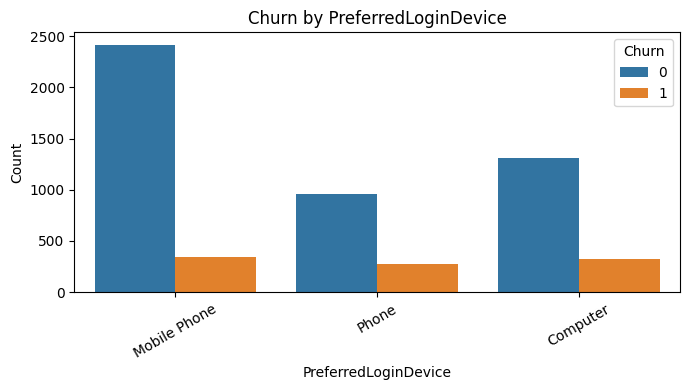

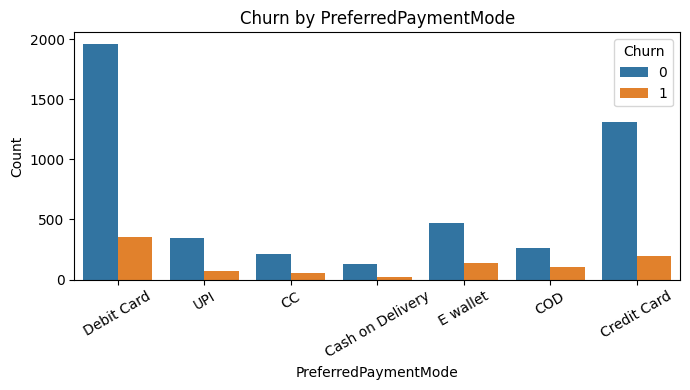

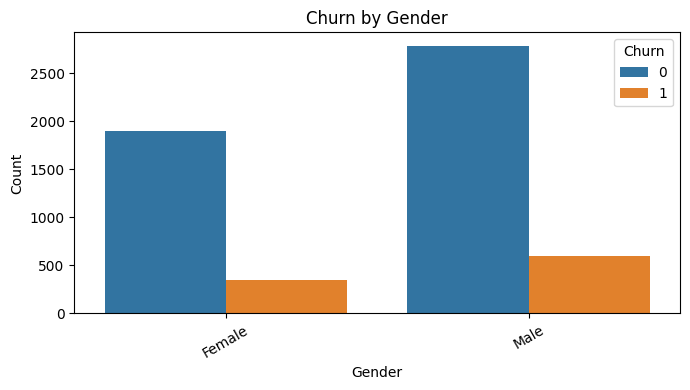

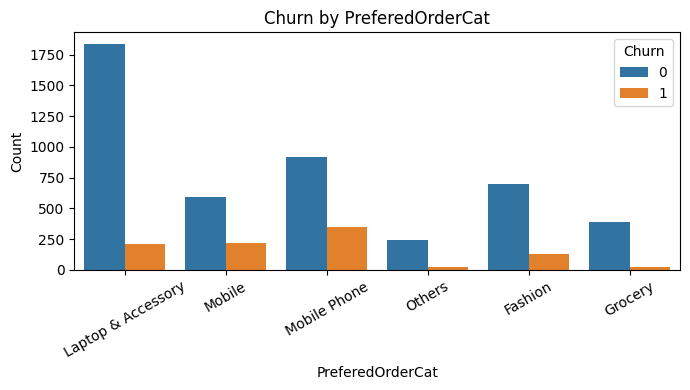

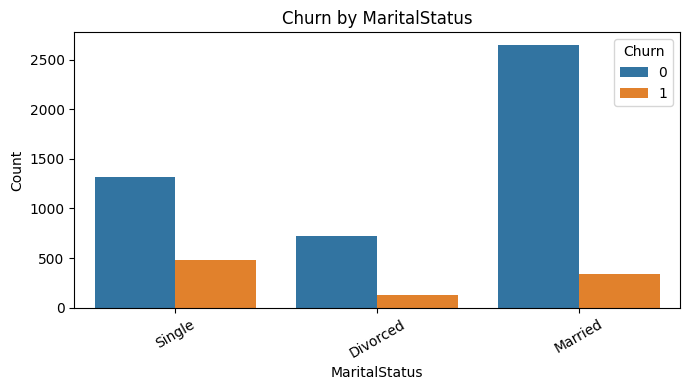

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'CustomerID']


for col in categorical_cols:
    plt.figure(figsize=(7, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Churn')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

## Preprocess the data and train the models (Logistic Regression & Random Forest)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Drop CustomerID and split features/target
df = df.drop(columns=["CustomerID"])
X = df.drop("Churn", axis=1)
y = df["Churn"]

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Identify column types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != "Churn"]

# 4. Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("cat", categorical_transformer, categorical_cols),
    ("num", numerical_transformer, numerical_cols)
])

# 5. Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# 6. Train and evaluate each model
results = []

trained_pipelines = {}
for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    clf.fit(X_train, y_train)
    trained_pipelines[name] = clf

    y_pred = clf.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    })

# 7. Show results
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.915631   0.868852  0.572973  0.690554
1        Random Forest  0.975133   0.993711  0.854054  0.918605


## Compare performance of the 2 models and implement one with better performance

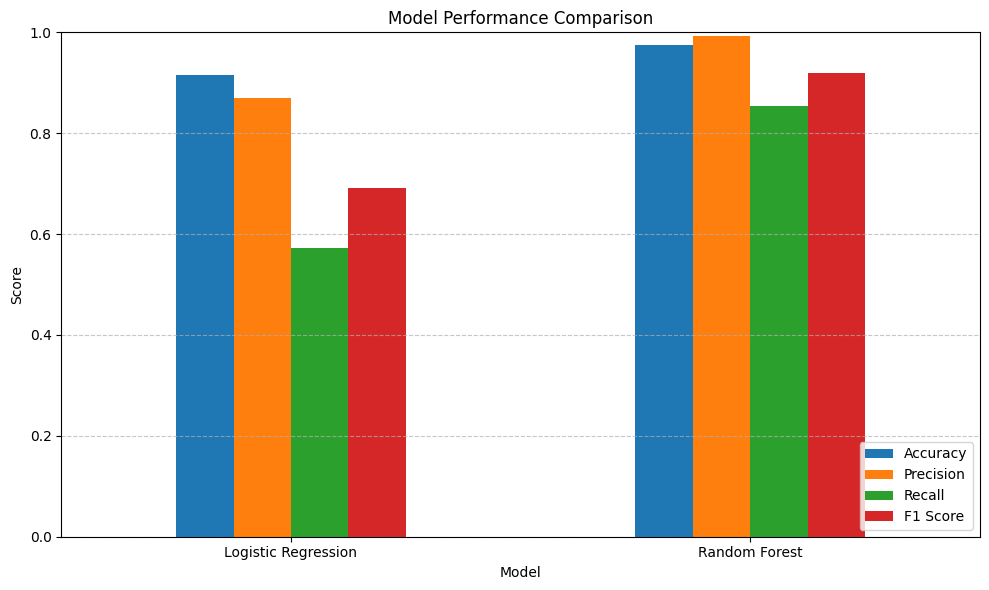

In [4]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
results_df.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6), ylim=(0, 1))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

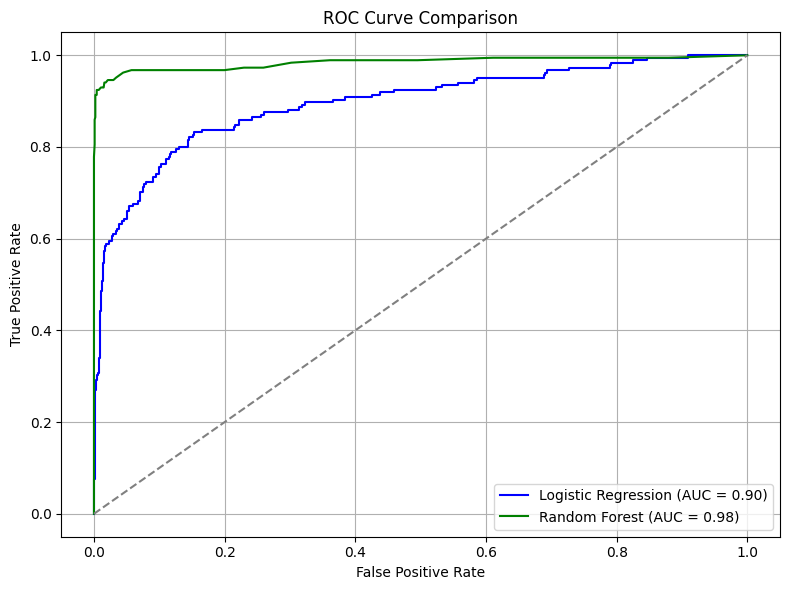

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (label=1)
y_probs_logreg = trained_pipelines["Logistic Regression"].predict_proba(X_test)[:, 1]
y_probs_rf = trained_pipelines["Random Forest"].predict_proba(X_test)[:, 1]

# Compute False Positive Rate and True Positive Rate
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_probs_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)

# Compute AUC
auc_logreg = roc_auc_score(y_test, y_probs_logreg)
auc_rf = roc_auc_score(y_test, y_probs_rf)

plt.figure(figsize=(8, 6))

plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {auc_logreg:.2f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='green')

# Plot the diagonal line (no skill)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [6]:
# implemented Random Forest for later churn prediction as it has a better performance compared to Logistic Regression
import joblib
joblib.dump(clf, 'churn_model.pkl')

['churn_model.pkl']

In [7]:
clf.named_steps["classifier"]

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Import Gradio for web interface for model prediction

In [8]:
import gradio as gr

# Reload trained pipeline (to simulate final app)
pipeline = joblib.load('churn_model.pkl')

# Define input feature names
feature_names = X.columns.tolist()

def predict_churn(*inputs):
    import pandas as pd
    data = pd.DataFrame([inputs], columns=feature_names)
    prediction = pipeline.predict(data)[0]
    prob = pipeline.predict_proba(data)[0][1]
    return f"Churn: {'Yes' if prediction else 'No'} (Probability: {prob:.2%})"

# Create Gradio UI components dynamically
gr_inputs = []
for col in feature_names:
    if col in categorical_cols:
        options = sorted(df[col].dropna().unique())
        gr_inputs.append(gr.Dropdown(choices=options, label=col))
    else:
        gr_inputs.append(gr.Number(label=col))

gr.Interface(
    fn=predict_churn,
    inputs=gr_inputs,
    outputs=gr.Text(label="Churn Prediction"),
    title="Customer Churn Predictor",
    description="Enter customer details to predict churn probability."
).launch()

/Users/lawrence/Desktop/Datascience project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Graphical presentation of the model's performance for Random Forest

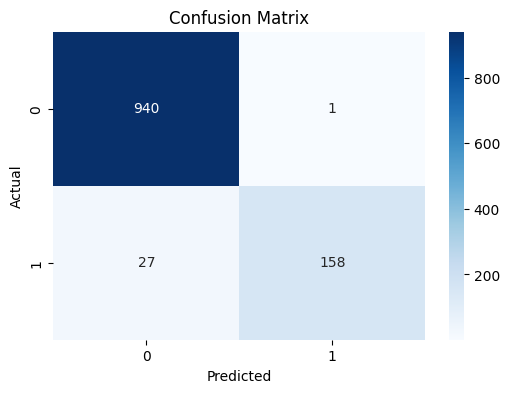

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       941
           1       0.99      0.85      0.92       185

    accuracy                           0.98      1126
   macro avg       0.98      0.93      0.95      1126
weighted avg       0.98      0.98      0.97      1126



In [11]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_names = numerical_cols + categorical_cols

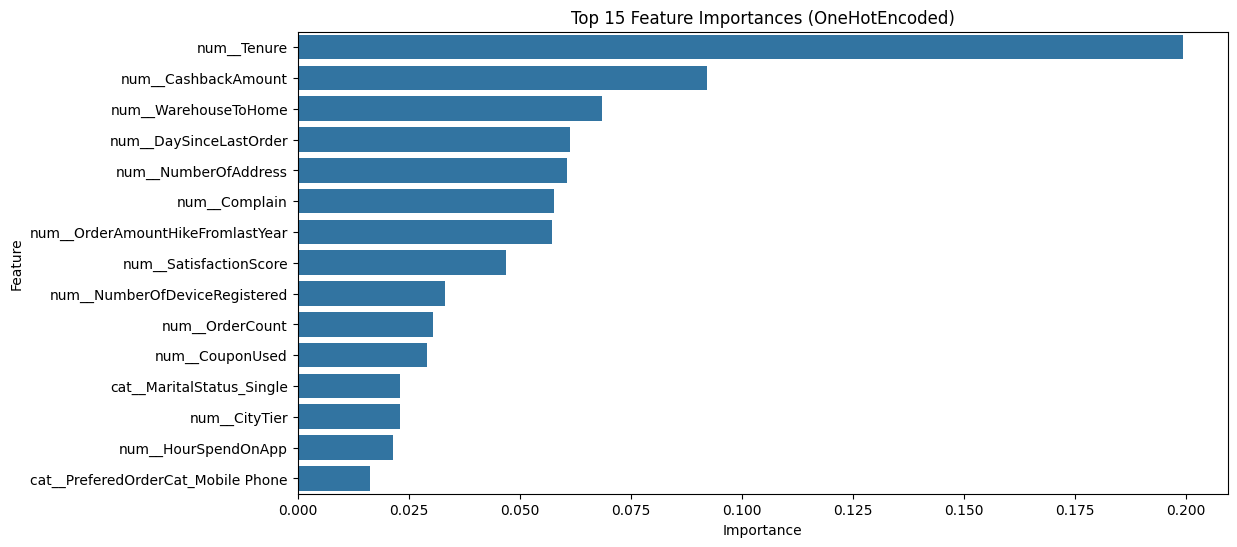

In [12]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pipeline.named_steps['classifier'].feature_importances_

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (OneHotEncoded)")
plt.show()

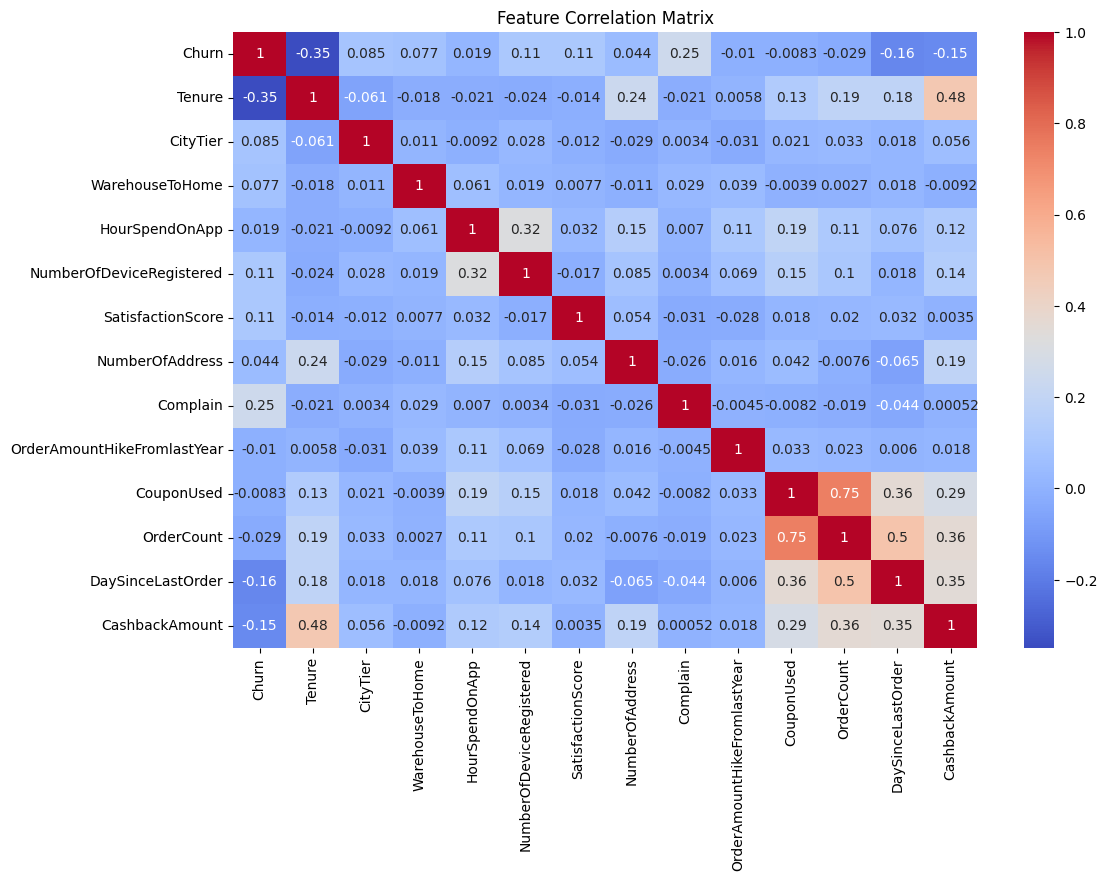

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only include numeric features (one-hot encoding will distort correlation for categories)
numeric_features = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

## Graphical presentation of the model's performance for Logistic Regression

In [14]:
logreg_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [17]:
import numpy as np

logreg_model = logreg_clf.named_steps["classifier"]

# Get transformed feature names

categorical_features = preprocessor.named_transformers_["cat"]["encoder"].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([categorical_features, numerical_cols])

In [18]:
logreg_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
logreg_clf.fit(X_train, y_train)

# Extract coefficients
coefficients = logreg_model.coef_[0]  # shape: (1, n_features)

coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefficients
})

print(coef_df)

# Sort by absolute value
coef_df["AbsCoeff"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("AbsCoeff", ascending=False).drop("AbsCoeff", axis=1)

# Saved the result with an .md format under the same folder for visibility on GitHub
with open("logistic_model_summary.md", "w") as f:
    f.write("# Logistic Regression Coefficients - Churn Prediction\n\n")
    for _, row in coef_df.iterrows():
        sign = "↑" if row["Coefficient"] > 0 else "↓"
        f.write(f"- **{row['Feature']}**: {sign} Coefficient = {row['Coefficient']:.3f}\n")


                                  Feature  Coefficient
0           PreferredLoginDevice_Computer     0.117792
1       PreferredLoginDevice_Mobile Phone    -0.313887
2              PreferredLoginDevice_Phone    -0.416619
3                 PreferredPaymentMode_CC    -0.485540
4                PreferredPaymentMode_COD     0.074193
5   PreferredPaymentMode_Cash on Delivery     0.579214
6        PreferredPaymentMode_Credit Card    -0.409701
7         PreferredPaymentMode_Debit Card    -0.204973
8           PreferredPaymentMode_E wallet     0.229378
9                PreferredPaymentMode_UPI    -0.395286
10                          Gender_Female    -0.506562
11                            Gender_Male    -0.106151
12               PreferedOrderCat_Fashion    -0.044122
13               PreferedOrderCat_Grocery     0.414409
14    PreferedOrderCat_Laptop & Accessory    -1.679767
15                PreferedOrderCat_Mobile    -0.447185
16          PreferedOrderCat_Mobile Phone    -0.703498
17        

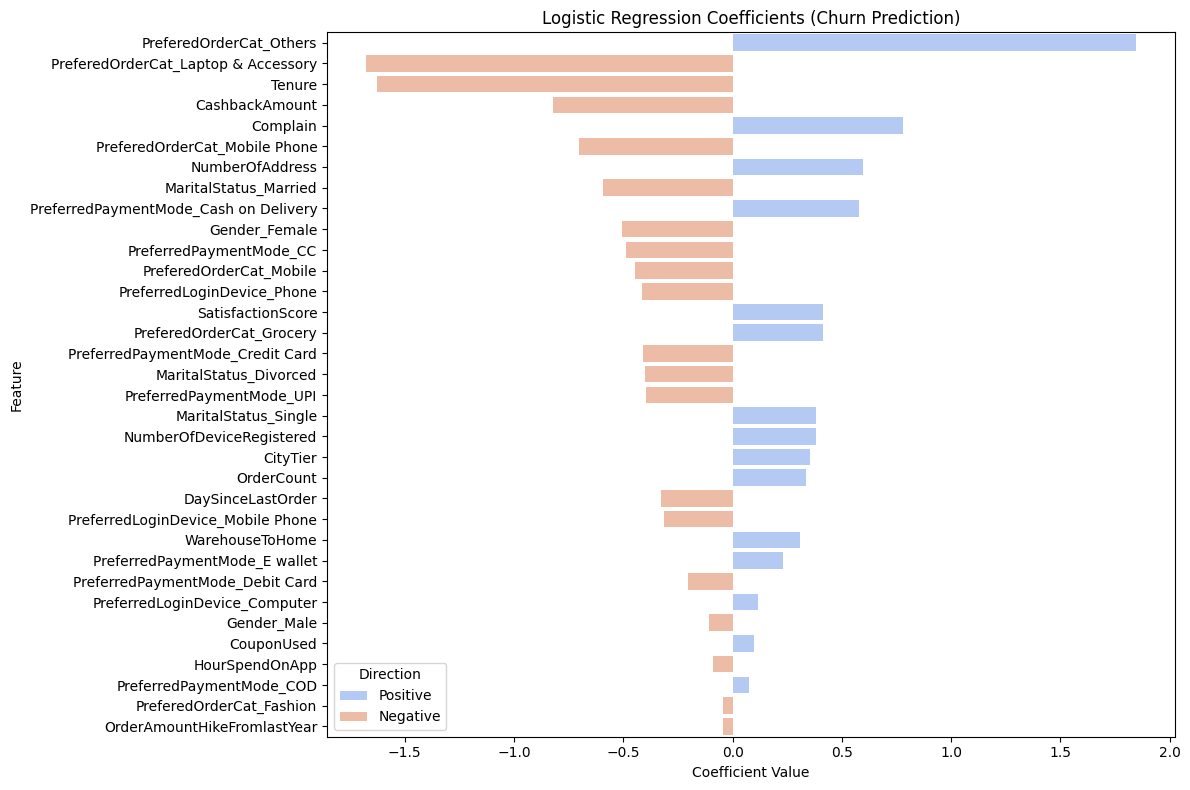

In [19]:
plt.figure(figsize=(12, 8))
coef_df["Direction"] = coef_df["Coefficient"].apply(lambda x: "Positive" if x > 0 else "Negative")
sns.barplot(data=coef_df, x="Coefficient", y="Feature", hue="Direction", palette="coolwarm")
plt.title("Logistic Regression Coefficients (Churn Prediction)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()